**<h1> Analisis Klasterisasi Kabupaten/Kota di Provinsi Sumatera Barat Berdasarkan Indikator Sosio-Ekonomi**

<p align="center">
  <img src="https://images.unsplash.com/photo-1653910729824-df4f32c60acf?q=80&w=1332&auto=format&fit=crop" width="600"/>
</p>

Analisis ini didasarkan pada empat indikator utama yang merefleksikan kondisi ketenagakerjaan dan tingkat pendidikan, yaitu:

* Tingkat Pengangguran Terbuka (TPT) (persentase angkatan kerja yang
tidak bekerja dan sedang mencari pekerjaan)
* Tingkat Partisipasi Angkatan Kerja (TPAK) (persentase penduduk usia kerja yang aktif secara ekonomi)
* Tingkat Setengah Pengangguran (persentase angkatan kerja yang bekerja di bawah jam kerja normal dan masih mencari pekerjaan tambahan)
* Rata-rata Lama Sekolah

**<h2>Import Library**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

**<h2>Exploratory Data Analysis (EDA)**

In [ ]:
df=pd.read_excel('/content/data project TPT Sumbar 2017-2025.xlsx')
df.head()

,No.,Kab/Kota,Tahun,TPT (%),TPAK (%),Tingkat Setengah Pengangguran,Rata-rata lama sekolah
0,1,Kab. Kepulauan Mentawai,2017,1.96,77.95,44.87,6.69
1,2,Kab. Pesisir Selatan,2017,5.95,64.03,40.45,8.13
2,3,Kab. Solok,2017,6.05,67.50,32.56,7.60
3,4,Kab. Sijunjung,2017,3.32,68.21,46.79,7.72
4,5,Kab. Tanah Datar,2017,3.72,66.51,42.56,8.14


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   No.                            152 non-null    int64  
 1   Kab/Kota                       152 non-null    object 
 2   Tahun                          152 non-null    int64  
 3   TPT (%)                        152 non-null    float64
 4   TPAK (%)                       152 non-null    float64
 5   Tingkat Setengah Pengangguran  152 non-null    float64
 6   Rata-rata lama sekolah         152 non-null    float64
dtypes: float64(4), int64(2), object(1)
memory usage: 8.4+ KB


In [ ]:
df.isna().sum()

,0
No.,0
Kab/Kota,0
Tahun,0
TPT (%),0
TPAK (%),0
Tingkat Setengah Pengangguran,0
Rata-rata lama sekolah,0


In [ ]:
df.duplicated().sum()

np.int64(0)

Data tidak memiliki missing value dan duplikasi, sehingga layak untuk analisis lanjutan.

**<h2>Feature Engineering Data Panel**

In [ ]:
df_panel = (
    df.groupby('Kab/Kota')
      .agg(
          TPT_mean=('TPT (%)', 'mean'),
          TPAK_mean=('TPAK (%)', 'mean'),
          SP_mean=('Tingkat Setengah Pengangguran', 'mean'),
          RLS_mean=('Rata-rata lama sekolah', 'mean')
      )
      .reset_index()
)

df_panel.head()

,Kab/Kota,TPT_mean,TPAK_mean,SP_mean,RLS_mean
0,Kab. Agam,4.77875,69.08625,35.06750,8.91125
1,Kab. Dharmasraya,5.19375,71.17125,38.69125,8.52750
2,Kab. Kepulauan Mentawai,2.26500,80.25750,47.49750,7.28500
3,Kab. Lima Puluh Kota,3.03250,73.04875,37.44250,8.03750
4,Kab. Padang Pariaman,7.02250,65.93625,36.65000,7.91375


In [ ]:
df_panel.describe()

,TPT_mean,TPAK_mean,SP_mean,RLS_mean
count,19.000000,19.000000,19.000000,19.000000
mean,5.337303,69.595329,34.897763,9.245066
std,1.713781,3.762643,8.160614,1.482638
min,2.265000,63.872500,21.713750,7.285000
25%,4.696250,66.903750,27.800625,8.100625
50%,5.250000,69.086250,37.442500,8.527500
75%,5.666875,71.269375,41.287500,10.655000
max,10.863750,80.257500,47.497500,11.678750


In [ ]:
df_panel.corr(numeric_only=True)

,TPT_mean,TPAK_mean,SP_mean,RLS_mean
TPT_mean,1.000000,-0.724168,-0.572676,0.527921
TPAK_mean,-0.724168,1.000000,0.531908,-0.549947
SP_mean,-0.572676,0.531908,1.000000,-0.953313
RLS_mean,0.527921,-0.549947,-0.953313,1.000000


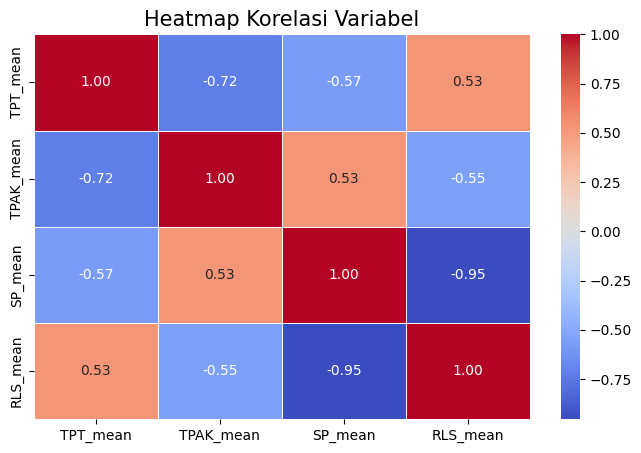

In [ ]:
corr_matrix = df_panel.corr(numeric_only=True)
plt.figure(figsize=(8, 5))

sns.heatmap(corr_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=0.5)

plt.title('Heatmap Korelasi Variabel', fontsize=15)
plt.show()

Korelasi tinggi antar variabel menyebabkan redundansi informasi dan multikolinearitas, sehingga PCA diperlukan untuk mereduksi dimensi data tanpa kehilangan informasi utama.

 **<h2>Standardisasi (Z-score)**

In [ ]:
X = df_panel.drop(columns='Kab/Kota')
kab_kota = df_panel['Kab/Kota']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Standarisasi score digunakan untuk menghilangkan bias skala dan wajib sebelum PCA & K-Means

**<h2> K-Means Awal (Tanpa PCA)**

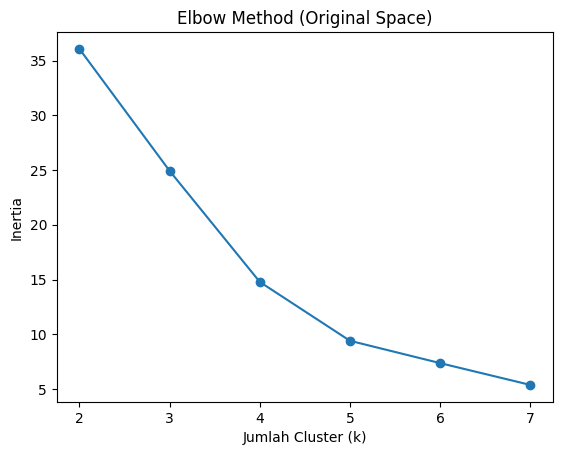

In [ ]:
inertia = []

for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(range(2, 8), inertia, marker='o')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method (Original Space)')
plt.show()

In [ ]:
print("k | Silhouette | Davies-Bouldin")
print("-"*35)

for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_scaled)

    sil = silhouette_score(X_scaled, labels)
    dbi = davies_bouldin_score(X_scaled, labels)

    print(f"{k:>2} | {sil:.3f}      | {dbi:.3f}")

k | Silhouette | Davies-Bouldin
-----------------------------------
 2 | 0.473      | 0.768
 3 | 0.389      | 0.843
 4 | 0.459      | 0.442
 5 | 0.387      | 0.537
 6 | 0.353      | 0.614
 7 | 0.301      | 0.667


**<h2>Principal Component Analysis (PCA)**

In [ ]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [ ]:
explained_var = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_var)

for i, (ev, cv) in enumerate(zip(explained_var, cum_var), start=1):
    print(f'PC{i}: {ev:.3f}, Cumulative: {cv:.3f}')

PC1: 0.734, Cumulative: 0.734
PC2: 0.185, Cumulative: 0.919
PC3: 0.070, Cumulative: 0.989
PC4: 0.011, Cumulative: 1.000


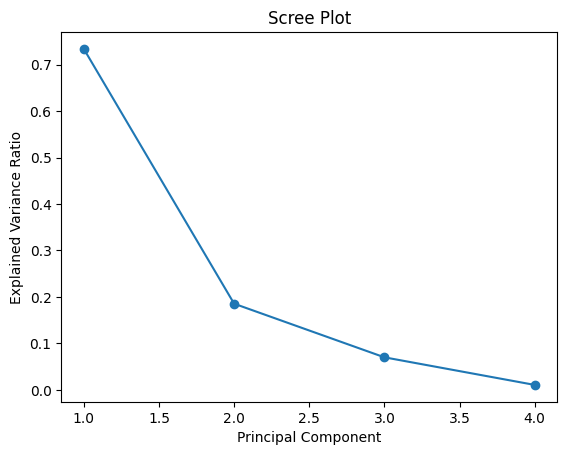

In [ ]:
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

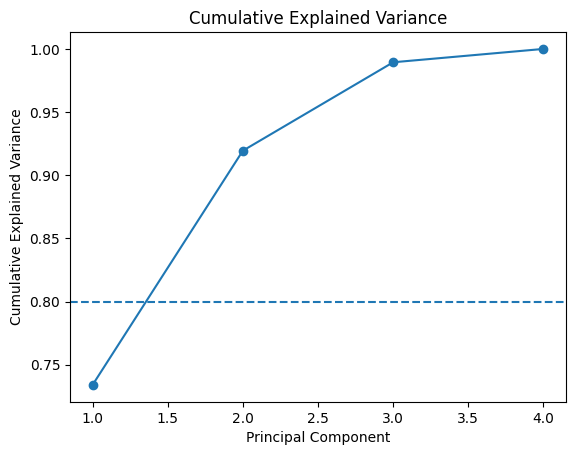

In [ ]:
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(0.8, linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.show()

Hasil output PCA dipilih 2 PC karena menjelaskan > 90% variasi secara kumulatif.

**<h2>Data PCA (Scores & Loadings)**

In [ ]:
pca_scores = pd.DataFrame(
    X_pca,
    columns=[f'PC{i+1}' for i in range(X_pca.shape[1])],
    index=kab_kota
)

X_pca_n = pca_scores[['PC1', 'PC2']]
X_pca_n.head()

,PC1,PC2
Kab/Kota,,
Kab. Agam,0.225869,-0.022895
Kab. Dharmasraya,0.755869,-0.187056
Kab. Kepulauan Mentawai,3.794771,1.115752
Kab. Lima Puluh Kota,1.707698,0.664941
Kab. Padang Pariaman,-0.351699,-1.603183


In [ ]:
pca_loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(X.shape[1])],
    index=X.columns
)

pca_loadings[['PC1', 'PC2']]

,PC1,PC2
TPT_mean,-0.475052,-0.516497
TPAK_mean,0.471298,0.534221
SP_mean,0.527657,-0.463406
RLS_mean,-0.523242,0.482798


Scores digunakan untuk mengelompokkan objek (Kab/Kota) sedangkan
Loadings digunakan untuk memahami makna ekonomi dari komponen utama

**<h2>K-Means di Ruang PCA (Final)**

In [ ]:
wcss = []
K = range(2, 8)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    km.fit(X_pca_n)
    wcss.append(km.inertia_)

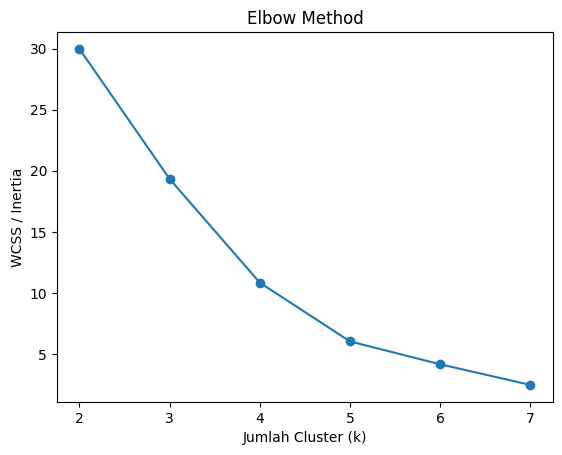

In [ ]:
plt.figure()
plt.plot(K, wcss, marker='o')
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("WCSS / Inertia")
plt.title("Elbow Method")
plt.show()

In [ ]:
print("k | Silhouette | Davies-Bouldin")
print("-"*35)

for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_pca_n)

    sil = silhouette_score(X_pca_n, labels)
    dbi = davies_bouldin_score(X_pca_n, labels)

    print(f"{k:>2} | {sil:.3f}      | {dbi:.3f}")

k | Silhouette | Davies-Bouldin
-----------------------------------
 2 | 0.529      | 0.656
 3 | 0.466      | 0.725
 4 | 0.485      | 0.565
 5 | 0.468      | 0.413
 6 | 0.487      | 0.412
 7 | 0.464      | 0.437


In [ ]:
k_final = 2

kmeans = KMeans(
    n_clusters=k_final,
    random_state=42,
    n_init=20
)

df_panel['Cluster'] = kmeans.fit_predict(X_pca_n) + 1

Dipilih berdasarkan nilai silhouette score tertinggi

In [ ]:
df_panel[['Kab/Kota', 'Cluster']].sort_values('Cluster')

,Kab/Kota,Cluster
0,Kab. Agam,1
1,Kab. Dharmasraya,1
2,Kab. Kepulauan Mentawai,1
3,Kab. Lima Puluh Kota,1
4,Kab. Padang Pariaman,1
5,Kab. Pasaman,1
6,Kab. Pasaman Barat,1
7,Kab. Pesisir Selatan,1
8,Kab. Sijunjung,1
9,Kab. Solok,1


In [ ]:
cluster_profile = df_panel.groupby('Cluster').mean(numeric_only=True)
cluster_profile

,TPT_mean,TPAK_mean,SP_mean,RLS_mean
Cluster,,,,
1,4.746042,70.721875,40.393646,8.197396
2,6.350893,67.664107,25.476250,11.041071


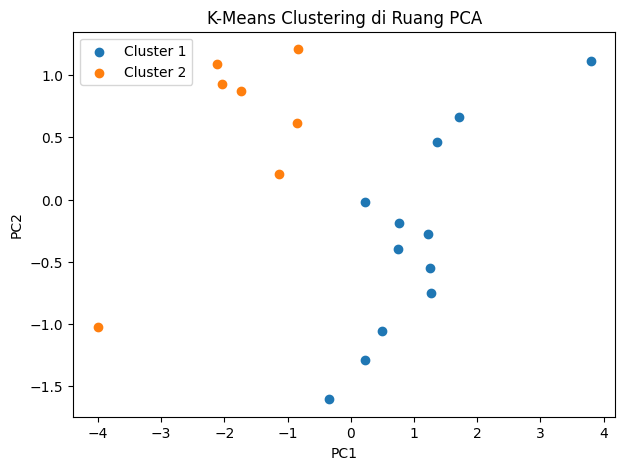

In [ ]:
plt.figure(figsize=(7,5))

X_vals = X_pca_n.values
clusters = df_panel['Cluster'].values

for c in np.unique(clusters):
    plt.scatter(
        X_vals[clusters == c, 0],
        X_vals[clusters == c, 1],
        label=f'Cluster {c}'
    )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('K-Means Clustering di Ruang PCA')
plt.show()

**<h2>Hierarchical Clustering**

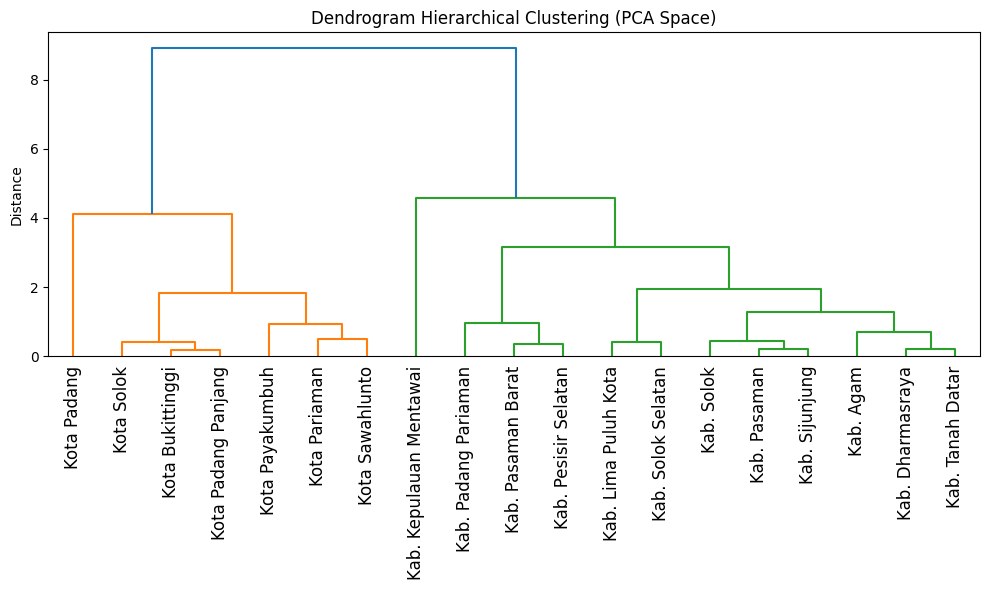

In [ ]:
Z = linkage(X_pca_n, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(
    Z,
    labels=X_pca_n.index.tolist(),
    leaf_rotation=90
)
plt.ylabel('Distance')
plt.title('Dendrogram Hierarchical Clustering (PCA Space)')
plt.tight_layout()
plt.show()

In [ ]:
k_hier = 2
df_panel['Cluster_H'] = fcluster(Z, k_hier, criterion='maxclust')

In [ ]:
cluster_profile_H = (
    df_panel
    .drop(columns='Kab/Kota')
    .groupby('Cluster_H')
    .mean()
)

cluster_profile_H[['TPT_mean','TPAK_mean','SP_mean','RLS_mean']]

,TPT_mean,TPAK_mean,SP_mean,RLS_mean
Cluster_H,,,,
1,6.350893,67.664107,25.476250,11.041071
2,4.746042,70.721875,40.393646,8.197396


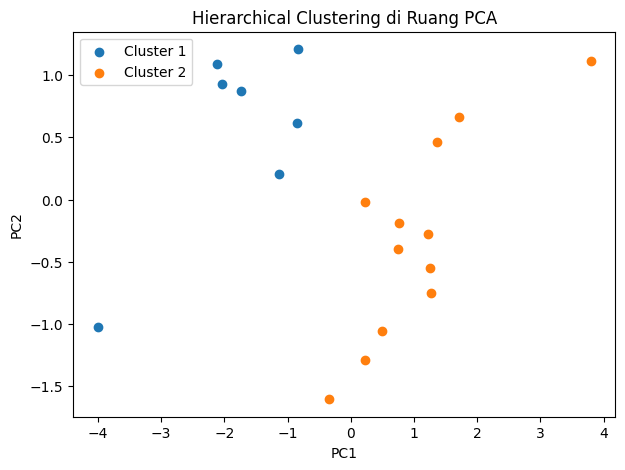

In [ ]:
plt.figure(figsize=(7,5))

X_vals = X_pca_n.values
clusters = df_panel['Cluster_H'].values

for c in np.unique(clusters):
    plt.scatter(
        X_vals[clusters == c, 0],
        X_vals[clusters == c, 1],
        label=f'Cluster {c}'
    )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('Hierarchical Clustering di Ruang PCA')
plt.show()

In [ ]:
df_panel.to_excel(
    '/content/hasil_clustering_TPT_Sumbar.xlsx',
    index=False
)

**<h2>Profilling**

Klaster 1: Wilayah dengan Keterlibatan Kerja Tinggi dan Pendidikan Dasar
Profil Klaster 0 menggambarkan 'dilema partisipasi kerja': tingginya TPAK (70.72%) dan rendahnya TPT (4.74%) sekilas tampak positif, namun realitasnya ditopang oleh tingginya angka setengah pengangguran (40.39%). Ini adalah cerminan ekonomi subsisten di mana penduduk 'harus bekerja' di sektor informal atau agraris yang tidak mensyaratkan pendidikan tinggi (rata-rata 8.19 tahun) meskipun pekerjaan tersebut tidak produktif atau memberikan penghasilan penuh.
Wilayah yang termasuk dalam klaster ini adalah:
* Kab. Agam
* Kab. Dharmasraya
* Kab. Kepulauan Mentawai
* Kab. Lima Puluh Kota
* Kab. Padang Pariaman
* Kab. Pasaman
* Kab. Pasaman Barat
* Kab. Pesisir Selatan
* Kab. Sijunjung
* Kab. Solok
* Kab. Solok Selatan
* Kab. Tanah Datar

Klaster 2: Wilayah Urban dengan Tingkat Pendidikan Tinggi dan Pengangguran Terbuka
Karakteristik Klaster 1 menyoroti 'paradoks wilayah urban': investasi pada pendidikan (rata-rata lama sekolah 11.04 tahun) berhasil menciptakan angkatan kerja yang lebih berkualitas, yang tercermin dari rendahnya tingkat setengah pengangguran (25.47%). Namun, pasar kerja formal belum mampu menyerap pasokan tenaga kerja terdidik ini sepenuhnya, mengakibatkan TPT yang lebih tinggi (6.35%). Ini mengindikasikan adanya skills mismatch atau keterbatasan lapangan kerja yang sesuai dengan kualifikasi pencari kerja.
Wilayah yang termasuk dalam klaster ini adalah:
* Kota Bukittinggi
* Kota Padang
* Kota Padang Panjang
* Kota Pariaman
* Kota Payakumbuh
* Kota Sawahlunto
* Kota Solok

Temuan yang jelas membedakan kedua kelompok wilayah ini selanjutnya diperkuat melalui proses validasi menggunakan metode analisis kedua.